In [311]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import glob
import os
import scipy.misc, scipy.stats
import numpy as np
import json

from skimage.draw import line_aa

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts")

import helper as helper
import CameraModel as CameraModel

plt.style.use('ggplot')

In [432]:

def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=1.0,
                               verbose=False,
                               percent_catchment=0.67,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    stddevs = scipy.stats.norm.ppf(percent_catchment)

    # 95% of positional ground error will have camera position error less than +-0.03
    # given are 1 stddev, want to use two
    xy_error = 2 * stddevs * sigma_pos if use_err_xy else 0
    z_error = (ground_distance/camera_height)*stddevs*sigma_pos if use_err_z else 0
        
    if use_err_orient:
        t = stddevs*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        orientation_error = np.tan(alpha + t)*camera_height - ground_distance
    else:
        orientation_error = 0
        
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
    if verbose:
        print("Position radius: {0}, orientation radius: {2}, pixel radius: {1}".format(position_error, pixel_error, orientation_error))
    total = xy_error + z_error + orientation_error + alg_error * pixel_error
    return total, xy_error, z_error, orientation_error, alg_error*pixel_error
    
    

In [465]:

    
   

def do_eval(real_position, 
            real_pitch_deg,
            real_yaw_deg,
            sigma_pos=0.03/2.0,
            sigma_orient_deg=0.5/2,
            alg_error=1.0,
            camera_res=(500,500),
            camera_fov=(60.0, 60.0),
            n_samples_per_camera=10,
            n_camera_instances=1,
            percent=0.67,
            use_err_xy=True,
            use_err_z=True,
            use_err_orient=True,
            use_err_pixel=True,
            verbose=False):
    
    real_camera = CameraModel.Camera(position=real_position, orientation_pitch_deg=real_pitch_deg, 
                                     orientation_yaw_deg=real_yaw_deg, verbose=False)
    real_camera.set_resolution(*camera_res)
    real_camera.set_fov(*camera_fov)

    results = {
        'true_vehicle_center':[], # placed using real_camera
        'calculated_vehicle_center':[], # project world -> biased camera -> round to pixel -> world
        'vehicle_center_prediction_error':[], # difference between above two
        'predicted_error_radius':[],
        'camera_biases':[], # enter tuples of (xyz, rp) bias
        'xy_errors': [],
        'z_errors': [],
        'orientation_errors': [],
        'pixel_alg_errors': []
    }
    for _ in range(n_camera_instances):
        offset_xyz = np.random.normal(loc=0.0, scale=sigma_pos, size=3)
        offset_rp = np.random.normal(loc=0.0, scale=sigma_orient_deg, size=2)
        biased_camera = CameraModel.Camera(position=real_position+offset_xyz, 
                                           orientation_pitch_deg=real_pitch_deg+offset_rp[0], 
                                           orientation_yaw_deg=real_yaw_deg+offset_rp[1],
                                           verbose=False
                                          )
        biased_camera.set_resolution(*camera_res)
        biased_camera.set_fov(*camera_fov)
        

        
        true_centers, calculated_centers, prediction_error, predicted_radius = [],[],[],[]
        xy_errors, z_errors, orientation_errors, pixel_alg_errors = [], [], [], []
        for i in range(n_samples_per_camera):
            
            # pick a uniformly distributed pixel to project through
            x,y = np.random.uniform(0, camera_res)
            # project through real camera to world coordinate to get something likely to be in FoV
            pt = real_camera.pixel_to_plane(x, y)
            true_centers.append(pt)
            
            # project world coordinate through biased camera
            pixel = biased_camera.world_to_pixel(*pt)
            # round to nearest pixel
            pixel = np.round(pixel)
            pixel_area = real_camera.plane_area_of_pixel(*pixel) # get area in true camera (will be wrong pixel)
            # project back onto ground to get estimate as if it were the true camera
            world_estimate = real_camera.pixel_to_plane(*pixel)
            calculated_centers.append(world_estimate)
            
            if pt is None or world_estimate is None:
                continue
            # error
            error = np.linalg.norm(world_estimate - pt)
            prediction_error.append(error)
            
            # predicted error radius
            radius, xy_err, z_err, orientation_err, pixel_err  = get_predicted_error_radius(real_position[2],
                               ground_distance=np.linalg.norm(world_estimate[:2]), 
                               pixel_area=pixel_area,
                               sigma_pos=sigma_pos,
                               sigma_orient_deg=sigma_orient_deg,
                               alg_error=alg_error,
                               verbose=verbose,
                               percent_catchment=percent,  
                               use_err_xy=use_err_xy,
                               use_err_z=use_err_z,
                               use_err_orient=use_err_orient,
                               use_err_pixel=use_err_pixel
                              )
            
            predicted_radius.append(radius)
            xy_errors.append(xy_err)
            z_errors.append(z_err)
            orientation_errors.append(orientation_err)
            pixel_alg_errors.append(pixel_err)
            
            
            
            if verbose and radius < error:
                print("Offset XYZ: {0}, RP: {1}".format(offset_xyz, offset_rp))
                print("True pixel & ground area: {0}, {1}".format((x,y), real_camera.plane_area_of_pixel(*np.round([x,y]))))
                print("True world pos: {0}".format(pt))
                print("Biased pixel: {0}".format(pixel))
                print("Pixel Ground area in true camera: {0}".format(pixel_area))
                print("World pos estimate: {0}".format(world_estimate))
                print("Error: {0}".format(error))
                print("Predicted Error Radius: {0}".format(radius))
                print("-----------------")
        results['true_vehicle_center'].append(np.array(true_centers))
        results['calculated_vehicle_center'].append(np.array(calculated_centers))
        results['vehicle_center_prediction_error'].append(np.array(prediction_error))
        results['predicted_error_radius'].append(np.array(predicted_radius))
        results['camera_biases'].append(np.array([offset_xyz, offset_rp]))
        results['xy_errors'].append(xy_errors)
        results['z_errors'].append(z_errors)
        results['orientation_errors'].append(orientation_errors)
        results['pixel_alg_errors'].append(pixel_alg_errors)

    results['true_vehicle_center'] = np.array(results['true_vehicle_center'])
    results['calculated_vehicle_center'] = np.array(results['calculated_vehicle_center'])
    results['vehicle_center_prediction_error'] = np.array(results['vehicle_center_prediction_error'])
    results['predicted_error_radius'] = np.array(results['predicted_error_radius'])
    results['xy_errors'] = np.array(results['xy_errors'])
    results['z_errors'] = np.array(results['z_errors']) 
    results['orientation_errors'] = np.array(results['orientation_errors'])
    results['pixel_alg_errors'] = np.array(results['pixel_alg_errors'])

    return results




In [358]:
def evaluate_error_model(camera_height_range=(4.0, 10.0), 
                         camera_pitch_range=(32.0, 90.0), 
                         camera_pos_samples=100, 
                         camera_instances_per=50, 
                         samples_per_camera=50, 
                         sigma_pos=0.03/2, 
                         sigma_orient_deg=0.05/2, 
                         alg_error=1.0, 
                         use_err_xy=True,
                         use_err_z=True,
                         use_err_orient=True,
                         use_err_pixel=True,
                         percent=0.95
                        ):
    all_results = []
    
    for _ in range(camera_pos_samples):
        height, pitch = np.random.uniform(*np.array([camera_height_range, camera_pitch_range]).T)
        all_results.append(
            do_eval(np.array([0.0, 0.0, height]), 
                pitch,
                0.0,
                sigma_pos=sigma_pos,
                sigma_orient_deg=sigma_orient_deg,
                alg_error=alg_error,
                camera_res=(500,500),
                camera_fov=(60.0, 60.0),
                n_samples_per_camera=samples_per_camera,
                n_camera_instances=camera_instances_per,
                percent=percent,
                use_err_xy=use_err_xy,
                use_err_z=use_err_z,
                use_err_orient=use_err_orient,
                use_err_pixel=use_err_pixel
            )
        )
    return all_results
    
    

In [322]:
outlier_cutoff = 0.5

### 1 show without pixel error, radii are gaussian...ish

In [309]:
no_pixel = evaluate_error_model(camera_pos_samples=100, camera_instances_per=50, samples_per_camera=25,
                                use_err_pixel=False)

Number of outliers (>0.5) discarded: 1098/125000 ... 0.008784
Mean: 0.0860626339448, stddev: 3.15846268492e-06


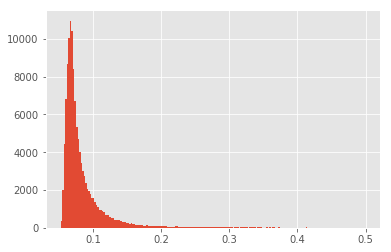

In [338]:
all_radii_no_pixel = np.array([res['predicted_error_radius'] for res in no_pixel]).ravel()
outliers = all_radii_no_pixel > outlier_cutoff
num_outliers, total = np.count_nonzero(outliers), all_radii_no_pixel.shape[0]
non_outliers = all_radii_no_pixel[~outliers]
plt.hist(non_outliers, bins=200)
print("Number of outliers (>{3}) discarded: {0}/{1} ... {2}".format(num_outliers, total, num_outliers/float(total), outlier_cutoff))
print("Mean: {0}, stddev: {1}".format(np.mean(non_outliers), np.var(non_outliers)**2 ))


### 1.5 show with pixel error, radii are less gaussian (linear error as a function of ) hmmm... ignore
This is actually more gaussian...

In [310]:
with_pixel_err = evaluate_error_model(camera_pos_samples=100, camera_instances_per=50, samples_per_camera=25,
                                use_err_pixel=True)

Number of outliers (>0.5) discarded: 2968/125000 ... 0.023744
Mean: 0.119036435898, stddev: 1.05319537582e-05


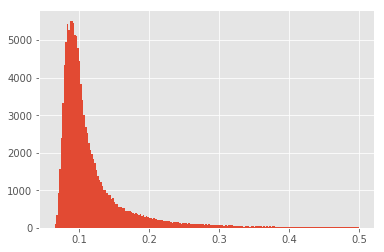

In [336]:
all_radii_with_pixel = np.array([res['predicted_error_radius'] for res in with_pixel_err]).ravel()
outliers = all_radii_with_pixel > outlier_cutoff
num_outliers, total = np.count_nonzero(outliers), all_radii_with_pixel.shape[0]
non_outliers = all_radii_with_pixel[~outliers]
plt.hist(non_outliers, bins=200)
print("Number of outliers (>{3}) discarded: {0}/{1} ... {2}".format(num_outliers, total, num_outliers/float(total), outlier_cutoff))
print("Mean: {0}, stddev: {1}".format(np.mean(non_outliers), np.var(non_outliers)**2 ))

### 2. Show that most of the true errors are less than the predicted ones

In [428]:
sampled_results = evaluate_error_model(camera_pos_samples=50, camera_instances_per=25, samples_per_camera=25,
                                      percent=0.67)

In [429]:
all_errors = np.array([res['vehicle_center_prediction_error'] for res in sampled_results]).ravel()
all_radii = np.array([res['predicted_error_radius'] for res in sampled_results]).ravel()
outlier_cutoff_2 = outlier_cutoff * 1
outliers = all_radii > outlier_cutoff_2 # remove all the ones with too high of a predicted error radius

# remove outliers
errors = all_errors[~outliers]
radii = all_radii[~outliers]

# count correctly within radius
errs_within_radii = errors < radii
n_within, n_total = np.count_nonzero(errs_within_radii), errors.shape[0]

print("Errors within predicted error radius: {0}/{1} ... {2}".format(n_within, n_total, float(n_within)/n_total))
print("Errors not within error radius: {0}/{1} ... {2}".format(n_total-n_within, n_total, float(n_total-n_within)/n_total))


Errors within predicted error radius: 29658/31057 ... 0.954953794636
Errors not within error radius: 1399/31057 ... 0.0450462053643


Mean positive difference: 0.0377636605161


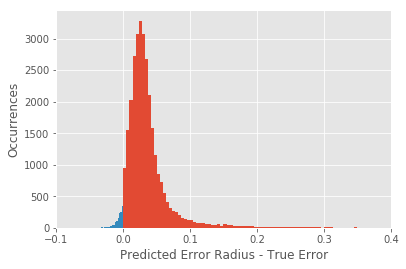

In [430]:
# examine distribution of differences
diffs = radii - errors
inside_diffs = diffs[diffs > 0]
outside_diffs = diffs[diffs < 0]
print("Mean positive difference: {0}".format(np.mean(diffs[diffs > 0])))
_ = plt.hist(inside_diffs, bins=100)
_ = plt.hist(outside_diffs, bins=100)
plt.xlim(-0.1, 0.4)
_ = plt.xlabel("Predicted Error Radius - True Error")
_ = plt.ylabel("Occurrences")

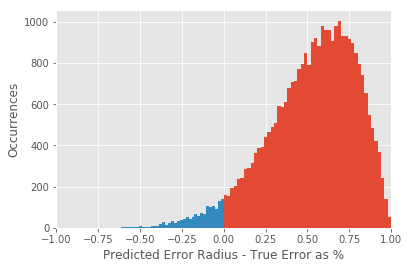

In [431]:
percent_diff = (diffs / radii)
negative_percents = percent_diff[percent_diff < 0]
positive_percents = percent_diff[percent_diff >= 0]
plt.xlim(-1, 1)
_ = plt.xlabel("Predicted Error Radius - True Error as %")
_ = plt.ylabel("Occurrences")
_ = plt.hist(positive_percents, bins=50)
_ = plt.hist(negative_percents, bins=50)


### 3. How components of the error vary as the pitch angle changes
1. instantiate camera at official angle 90 pitch -> 40 pitch, at 20 degree increments
2. randomly sample and collect components of the error
3. Show how the components grow on average as pitch angle changes (3 side by side bars for easy visual comparison)


In [603]:
vary_pitch_results = []
for pitch in np.arange(31.0, 92.0, 10.0):
    vary_pitch_results.append(do_eval(np.array([0.0, 0.0, 6.0]), 
                      pitch,
                      0.0,
                      n_samples_per_camera=50,
                      n_camera_instances=50
                    )
    )
    
    

In [604]:
vary_pitch_stats_summary = {}
for index, result in enumerate(vary_pitch_results):
    angle = 31 + 10*index
    vary_pitch_stats_summary[angle] = {}
    xy_errs = result['xy_errors'].ravel() # constant
    mean_xy, med_xy, stddev_xy = np.mean(xy_errs), np.median(xy_errs), np.var(xy_errs)**2
    vary_pitch_stats_summary[angle]['XY Error Radius'] = {
        'mean': mean_xy,
        'median': med_xy,
        'stddev': stddev_xy
    }
    
    z_errs = result['z_errors'].ravel()
    mean_z, med_z, stddev_z = np.mean(z_errs), np.median(z_errs), np.var(z_errs)**2
    vary_pitch_stats_summary[angle]['Z Error Radius']= {
        'mean': mean_z,
        'median': med_z,
        'stddev': stddev_z
    }

    orient_errs = result['orientation_errors'].ravel()
    mean_or, med_or, stddev_or = np.mean(orient_errs), np.median(orient_errs), np.var(orient_errs)**2
    vary_pitch_stats_summary[angle]['Orientation Error Radius']= {
        'mean': mean_or,
        'median': med_or,
        'stddev': stddev_or
    }

    pixel_alg_errs = result['pixel_alg_errors'].ravel()
    mean_p, med_p, stddev_p = np.mean(pixel_alg_errs), np.median(pixel_alg_errs), np.var(pixel_alg_errs)**2
    vary_pitch_stats_summary[angle]['Pixel and Algorithmic Error Radius']= {
        'mean': mean_p,
        'median': med_p,
        'stddev': stddev_p
    }
    
    mean_total = mean_xy + mean_z + mean_p + mean_or
    xy_mean_norm, z_mean_norm, or_mean_norm, p_mean_norm = mean_xy/mean_total, mean_z/mean_total, mean_or/mean_total, mean_p/mean_total
    
    med_total = med_xy + med_z + med_p + med_or
    xy_med_norm, z_med_norm, or_med_norm, p_med_norm = med_xy/med_total, med_z/med_total,med_or/med_total, med_p/med_total
    
    total_error_radii = result['predicted_error_radius'].ravel()
    mean, median, stddev = np.mean(total_error_radii), np.median(total_error_radii), np.var(total_error_radii)**2
    vary_pitch_stats_summary[angle]['total_error'] = {
        'mean': mean,
        "media": median,
        "stddev": stddev
    }
    
    vary_pitch_stats_summary[angle]["normalized_summary"] = {
        "means": {
            "xy error" : xy_mean_norm,
            "z error": z_mean_norm,
            "orientation error": or_mean_norm,
            "pixel and algorithm error": p_mean_norm
        },
        "medians": {
            "xy error" : xy_med_norm,
            "z error": z_med_norm,
            "orientation error": or_med_norm,
            "pixel and algorithm error": p_med_norm
        }
    }
    # TODO stick these in a summary dict
    # TODO make them into a figure of relative important as a function of pitch angle as a sanity check

In [605]:
print(json.dumps(vary_pitch_stats_summary, sort_keys=True, indent=4))

{
    "31": {
        "Orientation Error Radius": {
            "mean": 0.84095353729588729, 
            "median": 0.048257342021032379, 
            "stddev": 273.00362829838008
        }, 
        "Pixel and Algorithmic Error Radius": {
            "mean": 0.24119279055180715, 
            "median": 0.05251071825205484, 
            "stddev": 0.24400961298443968
        }, 
        "XY Error Radius": {
            "mean": 0.013197394970197018, 
            "median": 0.013197394970197016, 
            "stddev": 9.0556790788267124e-72
        }, 
        "Z Error Radius": {
            "mean": 0.027613179585746508, 
            "median": 0.011759377363916572, 
            "stddev": 4.6809654941342777e-06
        }, 
        "normalized_summary": {
            "means": {
                "orientation error": 0.74887427602596746, 
                "pixel and algorithm error": 0.21478365735634647, 
                "xy error": 0.011752361058513107, 
                "z error": 0.024589705559

In [653]:
def sidebyside_bar(series, xlabels, series_labels, ylabel, xlabel, error_bars=None, label_suffix="", label_multiplier=1, label_decimals=2, figsize=(8,6), width=0.27):
    if error_bars is None:
        error_bars = np.zeros_like(series)
        
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    n = series.shape[1]
    ind = np.arange(n)
    
    width = width * 3 / len(series_labels)
    
    rects = []
    for index, data in enumerate(series):
        yerr = error_bars[index]
        if yerr is None:
            yerr = np.zeros_like(data)
        rects.append(ax.bar(ind + width*index, data, width, yerr=yerr))
        
    ax.set_ylabel(ylabel)
    ax.set_xticks(ind + 0.5 * (len(series_labels) -1) *width)
    ax.set_xticklabels( xlabels )
    ax.legend( rects, series_labels)
    ax.set_xlabel(xlabel)
    
    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h+0.005, ('%.'+str(label_decimals)+'f')%float(h*label_multiplier) + label_suffix,
                    ha='center', va='bottom')
    
    for r in rects:
        autolabel(r)
    
    
    

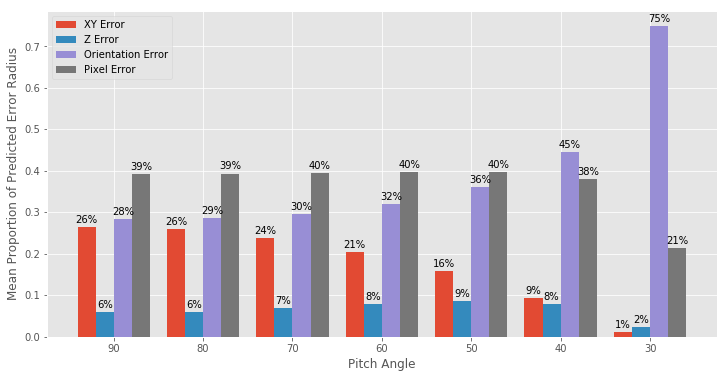

In [651]:
# collect summaries
# means first

angles = [90, 80, 70, 60, 50, 40, 30]
xy_means = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["means"]["xy error"] for angle in angles])
z_means = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["means"]["z error"] for angle in angles])
orientation_means =  np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["means"]["orientation error"] for angle in angles])
pixel_means = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["means"]["pixel and algorithm error"] for angle in angles])
legend = ["XY Error", "Z Error", "Orientation Error", "Pixel Error"]

sidebyside_bar(np.array([xy_means, z_means, orientation_means, pixel_means]), angles, legend, "Mean Proportion of Predicted Error Radius", "Pitch Angle", label_suffix="%", label_decimals=0, label_multiplier=100, figsize=(12,6))

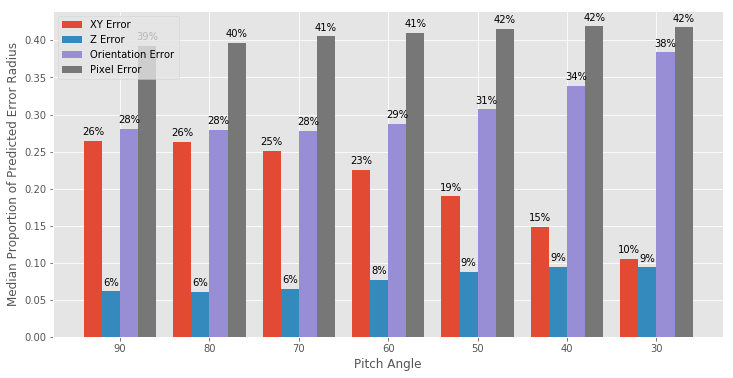

In [645]:
angles = [90, 80, 70, 60, 50, 40, 30]
xy_medians = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["medians"]["xy error"] for angle in angles])
z_medians = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["medians"]["z error"] for angle in angles])
orientation_medians =  np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["medians"]["orientation error"] for angle in angles])
pixel_medians = np.array([vary_pitch_stats_summary[angle + 1]["normalized_summary"]["medians"]["pixel and algorithm error"] for angle in angles])
legend = ["XY Error", "Z Error", "Orientation Error", "Pixel Error"]

sidebyside_bar(np.array([xy_medians, z_medians, orientation_medians, pixel_medians]), angles, legend, "Median Proportion of Predicted Error Radius", "Pitch Angle", label_suffix="%", label_multiplier=100, label_decimals=0, figsize=(12,6))

[  5.53535984e-11   6.35618109e-10   1.12958072e-08   1.45593780e-07
   2.44136025e-06   2.04925319e-04   5.27988415e+02]


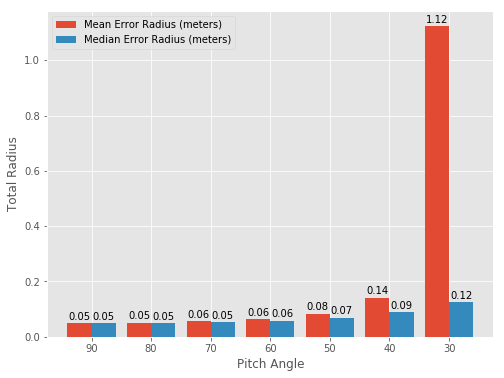

In [661]:
# show absolute errors 
angles = [90, 80, 70, 60, 50, 40, 30]
mean_error = np.array([vary_pitch_stats_summary[angle + 1]["total_error"]["mean"] for angle in angles])
median_error = np.array([vary_pitch_stats_summary[angle + 1]["total_error"]["media"] for angle in angles])
stddev_error = np.array([vary_pitch_stats_summary[angle + 1]["total_error"]["stddev"] for angle in angles])
legend=["Mean Error Radius (meters)", "Median Error Radius (meters)"]
print(stddev_error)
sidebyside_bar(np.array([mean_error, median_error]), angles, legend, "Total Radius", "Pitch Angle")
# error bars are nothing to write home about except that divergence at the top end - discuss in TABLE

### 4. Show impact of algorithmic error

In [257]:
sampled_results = evaluate_error_model()

In [296]:
all_errors = np.array([res['vehicle_center_prediction_error'] for res in sampled_results]).ravel()
all_radii = np.array([res['predicted_error_radius'] for res in sampled_results]).ravel()
outlier_cutoff = 2.0
outliers_errors = all_errors > outlier_cutoff 
outliers_radii = all_radii > outlier_cutoff
outliers = outliers_errors | outliers_radii
remaining_errors = all_errors[~outliers]
remaining_radii = all_radii[~outliers]

In [297]:
worst_error = np.argmax(all_errors)
error, radius = all_errors[worst_error], all_radii[worst_error]
print(error, radius)
worst_radius = np.argmax(all_radii)
rad_err, rad = all_errors[worst_radius], all_radii[worst_radius]
print(rad_err, rad)

(62.67893173104428, 69.063651492812497)
(25.634459370305347, 97.833254210208636)


In [298]:
all_incorrect_predict = all_radii < all_errors
print("Incorrect radius %: {0}".format(np.count_nonzero(all_predict)/float(all_predict.shape[0])))

Incorrect radius %: 0.00096


In [299]:
non_outlier_incorrect = remaining_radii < remaining_errors

(array([  5.89200000e+03,   4.43790000e+04,   8.27880000e+04,
          4.80430000e+04,   2.12900000e+04,   1.17770000e+04,
          7.48200000e+03,   5.15000000e+03,   3.84000000e+03,
          2.88100000e+03,   2.25900000e+03,   1.69900000e+03,
          1.33800000e+03,   1.10900000e+03,   9.24000000e+02,
          7.79000000e+02,   6.53000000e+02,   5.87000000e+02,
          5.05000000e+02,   4.27000000e+02,   4.06000000e+02,
          3.55000000e+02,   3.42000000e+02,   3.25000000e+02,
          2.60000000e+02,   2.41000000e+02,   2.37000000e+02,
          2.01000000e+02,   1.81000000e+02,   1.80000000e+02,
          1.39000000e+02,   1.43000000e+02,   1.24000000e+02,
          1.11000000e+02,   9.30000000e+01,   8.60000000e+01,
          9.40000000e+01,   7.80000000e+01,   9.40000000e+01,
          7.10000000e+01,   6.60000000e+01,   6.60000000e+01,
          8.70000000e+01,   5.60000000e+01,   4.50000000e+01,
          6.00000000e+01,   4.70000000e+01,   4.40000000e+01,
        

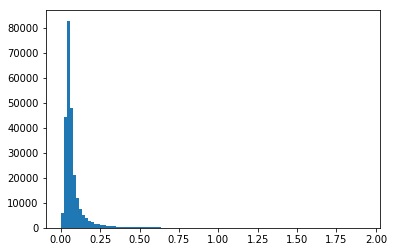

In [300]:
non_outlier_diffs = remaining_radii - remaining_errors
plt.hist(non_outlier_diffs[~non_outlier_incorrect], bins=100)

In [302]:
np.mean(all_radii - all_errors)

0.096502963209542297

In [249]:
results = do_eval(np.array([0.0, 0.0, 6.0]), 90.0, 0.0, n_camera_instances=100, n_samples_per_camera=100, percent=0.9, sigma_pos=0.03/2, sigma_orient_deg=0.05/2)

In [250]:
np.max(results['vehicle_center_prediction_error'])

0.071639317359046897

In [251]:
np.max(results['predicted_error_radius'])

0.059870150396394456

In [252]:
radii = results['predicted_error_radius'].ravel()
errors = results['vehicle_center_prediction_error'].ravel()

In [253]:
mispredict = radii < errors
print("Incorrect radius %: {0}".format(np.count_nonzero(mispredict)/float(mispredict.shape[0])))

Incorrect radius %: 0.0108


(array([  1.95000000e+02,   4.86000000e+02,   7.85000000e+02,
          1.07300000e+03,   1.36200000e+03,   1.54000000e+03,
          1.73100000e+03,   1.97000000e+03,   2.16000000e+03,
          2.37700000e+03,   2.56500000e+03,   2.74100000e+03,
          2.89700000e+03,   2.94100000e+03,   3.04300000e+03,
          3.06100000e+03,   3.15300000e+03,   3.17000000e+03,
          3.09000000e+03,   3.07300000e+03,   3.06100000e+03,
          2.92700000e+03,   2.90300000e+03,   2.89600000e+03,
          2.89700000e+03,   2.63800000e+03,   2.61200000e+03,
          2.41400000e+03,   2.33900000e+03,   2.18700000e+03,
          2.07900000e+03,   1.97700000e+03,   1.80600000e+03,
          1.77900000e+03,   1.66700000e+03,   1.51300000e+03,
          1.42600000e+03,   1.37900000e+03,   1.31100000e+03,
          1.17300000e+03,   1.06600000e+03,   1.05500000e+03,
          9.59000000e+02,   8.07000000e+02,   7.55000000e+02,
          7.64000000e+02,   6.97000000e+02,   6.56000000e+02,
        

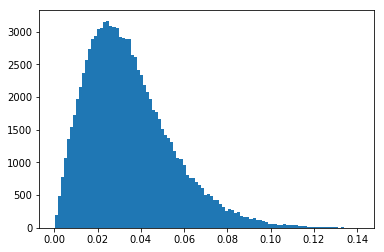

In [174]:
plt.hist(errors, bins=100)

(array([  332.,   824.,  1203.,  1534.,  1810.,  2014.,  2285.,  2443.,
         2450.,  2458.,  2699.,  2841.,  2872.,  2881.,  3060.,  3080.,
         3002.,  3112.,  3359.,  3269.,  3390.,  3477.,  3306.,  3500.,
         3475.,  3492.,  3599.,  3524.,  3480.,  2903.,  2417.,  2162.,
         1884.,  1653.,  1521.,  1326.,  1152.,  1191.,   905.,   792.,
          701.,   630.,   540.,   429.,   343.,   308.,   181.,   126.,
           49.,    16.]),
 array([ 0.08733163,  0.08833005,  0.08932847,  0.09032689,  0.09132531,
         0.09232373,  0.09332215,  0.09432058,  0.095319  ,  0.09631742,
         0.09731584,  0.09831426,  0.09931268,  0.1003111 ,  0.10130952,
         0.10230794,  0.10330636,  0.10430479,  0.10530321,  0.10630163,
         0.10730005,  0.10829847,  0.10929689,  0.11029531,  0.11129373,
         0.11229215,  0.11329057,  0.114289  ,  0.11528742,  0.11628584,
         0.11728426,  0.11828268,  0.1192811 ,  0.12027952,  0.12127794,
         0.12227636,  0.1232747

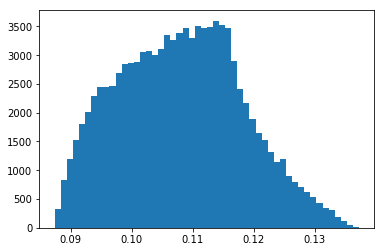

In [175]:
plt.hist(radii, bins=50)

In [162]:
results_45deg = do_eval(np.array([0.0, 0.0, 6.0]), 55.0, 0.0, n_camera_instances=50, n_samples_per_camera=50, verbose=True, percent=0.6)

Position radius: 0.00960692900926, orientation radius: 0.0221557963272, pixel radius: 0.0413244880784
Position radius: 0.00819096652704, orientation radius: 0.0155066280842, pixel radius: 0.0336868954146
Position radius: 0.00604331906823, orientation radius: 0.00894930748955, pixel radius: 0.0231227501697
Position radius: 0.00760519800617, orientation radius: 0.0132966588288, pixel radius: 0.0277210905637
Position radius: 0.00591747303197, orientation radius: 0.00869680488023, pixel radius: 0.0220383258875
Position radius: 0.00701027725478, orientation radius: 0.0113758339611, pixel radius: 0.0286485319304
Position radius: 0.00592981144609, orientation radius: 0.00872091674705, pixel radius: 0.0187283408648
Position radius: 0.010814940065, orientation radius: 0.0292915647425, pixel radius: 0.0489483943754
Position radius: 0.00669052530513, orientation radius: 0.0104781591604, pixel radius: 0.027582847588
Position radius: 0.00992567840922, orientation radius: 0.0239077596628, pixel radi

Predicted Error Radius: 0.0324537879282
-----------------
Position radius: 0.00824248904116, orientation radius: 0.01571614635, pixel radius: 0.0337831762083
Offset XYZ: [ 0.03435201  0.0184028  -0.01074035], RP: [-0.25156249  0.36113377]
True pixel & ground area: (383.18842463070843, 346.58702487784461), 0.000583894414612
True world pos: [  6.56495506e+00  -2.66996996e+00   5.32907052e-15]
Biased pixel: [ 387.  343.]
Pixel Ground area in true camera: 0.00057065149736
World pos estimate: [  6.46163411e+00  -2.72762901e+00   3.55271368e-15]
Error: 0.118320688626
Predicted Error Radius: 0.0577418115995
-----------------
Position radius: 0.00440671657559, orientation radius: 0.00680275991834, pixel radius: 0.0165165008152
Offset XYZ: [ 0.03435201  0.0184028  -0.01074035], RP: [-0.25156249  0.36113377]
True pixel & ground area: (294.88927731857098, 27.411310155134927), 0.000138844450926
True world pos: [  8.21335106e-01  -5.58353434e-01   4.44089210e-15]
Biased pixel: [ 297.   22.]
Pixel G

-----------------
Position radius: 0.00732653511726, orientation radius: 0.0123563381897, pixel radius: 0.0305028824295
Offset XYZ: [-0.0125001   0.02095346 -0.01444217], RP: [ 0.03393031  0.26566937]
True pixel & ground area: (193.01985239874236, 304.06475012271329), 0.000460282005408
True world pos: [  5.42464293e+00   1.05618878e+00   3.55271368e-15]
Biased pixel: [ 195.  306.]
Pixel Ground area in true camera: 0.000465212918255
World pos estimate: [  5.47279492e+00   1.02299266e+00   1.77635684e-15]
Error: 0.0584858642355
Predicted Error Radius: 0.0501857557365
-----------------
Position radius: 0.00635373166005, orientation radius: 0.00963445202345, pixel radius: 0.0252187960065
Offset XYZ: [-0.0125001   0.02095346 -0.01444217], RP: [ 0.03393031  0.26566937]
True pixel & ground area: (165.38273330946785, 228.30780035823238), 0.000315022286097
True world pos: [  3.76848010e+00   1.38284079e+00   4.44089210e-15]
Biased pixel: [ 168.  230.]
Pixel Ground area in true camera: 0.0003179

True pixel & ground area: (287.7202383939271, 106.34204767650706), 0.000186655133539
True world pos: [  1.79392673e+00  -5.17777089e-01   1.77635684e-15]
Biased pixel: [ 290.  105.]
Pixel Ground area in true camera: 0.000185922265015
World pos estimate: [  1.77570918e+00  -5.48105604e-01   3.55271368e-15]
Error: 0.035379343412
Predicted Error Radius: 0.0315318989005
-----------------
Position radius: 0.0101811809471, orientation radius: 0.0253798411778, pixel radius: 0.0443312951194
Offset XYZ: [ 0.00402111  0.02213919  0.02449946], RP: [-0.09626883  0.28457075]
True pixel & ground area: (99.432468901379295, 431.24988518320635), 0.000989391945958
True world pos: [  9.49588462e+00   3.60291897e+00   2.66453526e-15]
Biased pixel: [ 103.  430.]
Pixel Ground area in true camera: 0.000982631863484
World pos estimate: [  9.44438241e+00   3.50752334e+00   4.44089210e-15]
Error: 0.108410353265
Predicted Error Radius: 0.0798923172443
-----------------
Position radius: 0.00524844719772, orientat

Biased pixel: [  58.  249.]
Pixel Ground area in true camera: 0.00034818033943
World pos estimate: [  4.18062850e+00   3.24254200e+00   5.32907052e-15]
Error: 0.121196186057
Predicted Error Radius: 0.0453411204573
-----------------
Position radius: 0.00596161073839, orientation radius: 0.00878370509427, pixel radius: 0.0188736955597
Offset XYZ: [-0.01231008 -0.02617816  0.00676944], RP: [ 0.05413862 -0.16830983]
True pixel & ground area: (474.67228189838602, 92.240785111605831), 0.000176734741263
True world pos: [  1.60565660e+00  -3.02799493e+00   3.55271368e-15]
Biased pixel: [ 472.   94.]
Pixel Ground area in true camera: 0.000178108192041
World pos estimate: [  1.62877006e+00  -2.99877642e+00   3.55271368e-15]
Error: 0.0372552465229
Predicted Error Radius: 0.0336190113924
-----------------
Position radius: 0.00627616738628, orientation radius: 0.00945493932476, pixel radius: 0.0239685594222
Position radius: 0.0106701582401, orientation radius: 0.0283652275752, pixel radius: 0.04387

Offset XYZ: [-0.0029551   0.01315779  0.02857523], RP: [-0.33115469  0.22666339]
True pixel & ground area: (272.90261694949362, 280.64786450748318), 0.000408275732743
True world pos: [  4.86712655e+00  -4.07611325e-01   3.55271368e-15]
Biased pixel: [ 275.  277.]
Pixel Ground area in true camera: 0.000400042854259
World pos estimate: [  4.78425160e+00  -4.42195241e-01   3.55271368e-15]
Error: 0.0898014722393
Predicted Error Radius: 0.0460244484356
-----------------
Position radius: 0.00803297769542, orientation radius: 0.0148794205517, pixel radius: 0.0324757075089
Offset XYZ: [-0.0029551   0.01315779  0.02857523], RP: [-0.33115469  0.22666339]
True pixel & ground area: (392.47824480943393, 332.56477649230561), 0.000539250910048
True world pos: [  6.16892279e+00  -2.78145603e+00   2.66453526e-15]
Biased pixel: [ 394.  329.]
Pixel Ground area in true camera: 0.000527335789103
World pos estimate: [  6.07152495e+00  -2.79258554e+00   3.55271368e-15]
Error: 0.098031654416
Predicted Error R

World pos estimate: [  2.72230387e+00  -7.62782341e-01   3.55271368e-15]
Error: 0.0435109826679
Predicted Error Radius: 0.0356913087079
-----------------
Position radius: 0.00577532353025, orientation radius: 0.00842911881979, pixel radius: 0.0225205033466
Offset XYZ: [  2.83952532e-02   1.72425826e-05  -1.51214069e-02], RP: [-0.19967947  0.16632417]
True pixel & ground area: (174.58060023855509, 182.38634326034548), 0.000255810730186
True world pos: [  2.94262951e+00   1.15002245e+00   4.44089210e-15]
Biased pixel: [ 175.  180.]
Pixel Ground area in true camera: 0.000253586535493
World pos estimate: [  2.90272512e+00   1.13966293e+00   1.77635684e-15]
Error: 0.0412271769351
Predicted Error Radius: 0.0367249456967
-----------------
Position radius: 0.00458320792375, orientation radius: 0.0069157653714, pixel radius: 0.0168137080681
Offset XYZ: [  2.83952532e-02   1.72425826e-05  -1.51214069e-02], RP: [-0.19967947  0.16632417]
True pixel & ground area: (319.66304335382461, 36.3597869398

Position radius: 0.00543329462582, orientation radius: 0.00786121755826, pixel radius: 0.0178940632242
Offset XYZ: [ -8.05844589e-05  -8.81025771e-03  -2.87352048e-02], RP: [-0.31389069  0.02650092]
True pixel & ground area: (79.243624661258949, 68.550277151060655), 0.000161908728916
True world pos: [  1.30430217e+00   2.23318703e+00   3.55271368e-15]
Biased pixel: [ 78.  66.]
Pixel Ground area in true camera: 0.000160098749336
World pos estimate: [  1.27292234e+00   2.24230201e+00   4.44089210e-15]
Error: 0.0326768507945
Predicted Error Radius: 0.0311885754083
-----------------
Position radius: 0.0063232453769, orientation radius: 0.00956323476409, pixel radius: 0.0249252477244
Position radius: 0.00440145285549, orientation radius: 0.0067998292613, pixel radius: 0.0159201185008
Offset XYZ: [ -8.05844589e-05  -8.81025771e-03  -2.87352048e-02], RP: [-0.31389069  0.02650092]
True pixel & ground area: (185.82303918419146, 3.7840545860733932), 0.000128049616607
True world pos: [  5.6473145

Offset XYZ: [ 0.00260588  0.01024471 -0.00153891], RP: [-0.39342912 -0.54806219]
True pixel & ground area: (368.28065568106911, 4.186013040842651), 0.000128049616607
True world pos: [  5.68979608e-01  -1.43169086e+00   3.55271368e-15]
Biased pixel: [ 369.    1.]
Pixel Ground area in true camera: 0.00012672508654
World pos estimate: [  5.35415904e-01  -1.43510730e+00   3.55271368e-15]
Error: 0.0337371352314
Predicted Error Radius: 0.0277573462202
-----------------
Position radius: 0.00885979331736, orientation radius: 0.0184168259217, pixel radius: 0.0341729253829
Offset XYZ: [ 0.00260588  0.01024471 -0.00153891], RP: [-0.39342912 -0.54806219]
True pixel & ground area: (479.78591636558696, 348.85275263225253), 0.000590669735242
True world pos: [  6.63095244e+00  -4.62650571e+00   5.32907052e-15]
Biased pixel: [ 476.  347.]
Pixel Ground area in true camera: 0.000583894414612
World pos estimate: [  6.57694169e+00  -4.53411128e+00   3.55271368e-15]
Error: 0.107022862821
Predicted Error Rad

Biased pixel: [  52.  278.]
Pixel Ground area in true camera: 0.000402080169238
World pos estimate: [  4.80686847e+00   3.50811814e+00   2.66453526e-15]
Error: 0.0521193380975
Predicted Error Radius: 0.0490985166253
-----------------
Position radius: 0.00483703194312, orientation radius: 0.00712848530054, pixel radius: 0.0186205447952
Position radius: 0.00554331401019, orientation radius: 0.00803215114811, pixel radius: 0.0164000609576
Position radius: 0.0087542494416, orientation radius: 0.0179301646211, pixel radius: 0.0384026201974
Position radius: 0.00441233867025, orientation radius: 0.00680591822882, pixel radius: 0.0168742200048
Offset XYZ: [ 0.01390169 -0.03140379 -0.02449901], RP: [-0.06258194 -0.01862905]
True pixel & ground area: (223.69779776611631, 35.911232253941996), 0.000143398734564
True world pos: [  9.17210956e-01   3.30499214e-01   3.55271368e-15]
Biased pixel: [ 221.   34.]
Pixel Ground area in true camera: 0.000142369650384
World pos estimate: [  8.95482764e-01   

Offset XYZ: [-0.00249468 -0.00083076  0.02404092], RP: [-0.29377241 -0.04119625]
True pixel & ground area: (154.97127833260737, 168.38571816480064), 0.000240768540876
True world pos: [  2.71239563e+00   1.42005143e+00   5.32907052e-15]
Biased pixel: [ 155.  166.]
Pixel Ground area in true camera: 0.000238716758874
World pos estimate: [  2.67407882e+00   1.41480049e+00   4.44089210e-15]
Error: 0.0386749270746
Predicted Error Radius: 0.035890055124
-----------------
Position radius: 0.00823022327371, orientation radius: 0.0156660451377, pixel radius: 0.0319409611083
Offset XYZ: [-0.00249468 -0.00083076  0.02404092], RP: [-0.29377241 -0.04119625]
True pixel & ground area: (446.21502589135758, 326.42416699138118), 0.000518628826976
True world pos: [  6.00194468e+00  -3.78710459e+00   3.55271368e-15]
Biased pixel: [ 445.  323.]
Pixel Ground area in true camera: 0.000510112498262
World pos estimate: [  5.91046614e+00  -3.74002468e+00   2.66453526e-15]
Error: 0.102882656314
Predicted Error Ra

-----------------
Position radius: 0.00994491195616, orientation radius: 0.0240164755837, pixel radius: 0.0411898287608
Offset XYZ: [ 0.04849183  0.00057082  0.015625  ], RP: [-0.12023586 -0.01225839]
True pixel & ground area: (51.513711035894303, 410.93918578775117), 0.000865114370121
True world pos: [  8.69384178e+00   4.53869136e+00   2.66453526e-15]
Biased pixel: [  51.  408.]
Pixel Ground area in true camera: 0.00084830099667
World pos estimate: [  8.58363829e+00   4.52138862e+00   1.77635684e-15]
Error: 0.111553541783
Predicted Error Radius: 0.0751512163006
-----------------
Position radius: 0.00530636265066, orientation radius: 0.00767784047187, pixel radius: 0.0209923470857
Offset XYZ: [ 0.04849183  0.00057082  0.015625  ], RP: [-0.12023586 -0.01225839]
True pixel & ground area: (251.27075986483183, 151.94478680931601), 0.000224987200789
True world pos: [  2.45351943e+00  -1.85537037e-02   4.44089210e-15]
Biased pixel: [ 251.  147.]
Pixel Ground area in true camera: 0.000220339

Position radius: 0.0109347459055, orientation radius: 0.0300727495251, pixel radius: 0.0504165204161
Offset XYZ: [-0.01268528  0.00252984 -0.00953678], RP: [-0.20249889 -0.38438955]
True pixel & ground area: (170.01633643996578, 467.23779097784291), 0.00128044284811
True world pos: [  1.11164342e+01   2.08561665e+00   2.66453526e-15]
Biased pixel: [ 167.  466.]
Pixel Ground area in true camera: 0.00127091276543
World pos estimate: [  1.10558827e+01   2.15761200e+00   3.55271368e-15]
Error: 0.0940734709526
Predicted Error Radius: 0.0914240158467
-----------------
Position radius: 0.00990034062755, orientation radius: 0.023765061552, pixel radius: 0.0403970060284
Offset XYZ: [-0.01268528  0.00252984 -0.00953678], RP: [-0.20249889 -0.38438955]
True pixel & ground area: (39.604714733461165, 403.69633083894263), 0.000826554126575
True world pos: [  8.42478909e+00   4.73602549e+00   4.44089210e-15]
Biased pixel: [  37.  402.]
Pixel Ground area in true camera: 0.000815959048028
World pos esti

World pos estimate: [  2.42368084e+00   3.31989775e+00   2.66453526e-15]
Error: 0.0449771047094
Predicted Error Radius: 0.0372805814693
-----------------
Position radius: 0.00525629345153, orientation radius: 0.00760958177018, pixel radius: 0.0194358936972
Offset XYZ: [-0.00608038  0.01389702  0.00201791], RP: [ 0.33203766 -0.09389862]
True pixel & ground area: (147.57322161060648, 105.86611774451765), 0.000186655133539
True world pos: [  1.78745891e+00   1.40511144e+00   4.44089210e-15]
Biased pixel: [ 149.  109.]
Pixel Ground area in true camera: 0.000188876981905
World pos estimate: [  1.83019700e+00   1.39125638e+00   2.66453526e-15]
Error: 0.0449277984717
Predicted Error Radius: 0.0323017689189
-----------------
Position radius: 0.00668389505259, orientation radius: 0.0104605417905, pixel radius: 0.0235393247071
Offset XYZ: [-0.00608038  0.01389702  0.00201791], RP: [ 0.33203766 -0.09389862]
True pixel & ground area: (453.36476244684269, 196.45099474986654), 0.000272132501834
True

Offset XYZ: [ 0.01806151  0.00092824  0.01733331], RP: [ 0.43594499 -0.11484468]
True pixel & ground area: (461.21592926317902, 57.912499666072314), 0.000155402196358
True world pos: [  1.17471597e+00  -2.72606972e+00   4.44089210e-15]
Biased pixel: [ 460.   61.]
Pixel Ground area in true camera: 0.000157141600023
World pos estimate: [  1.21197526e+00  -2.72074067e+00   3.55271368e-15]
Error: 0.0376384544069
Predicted Error Radius: 0.0316863088833
-----------------
Position radius: 0.005785485353, orientation radius: 0.00844763777456, pixel radius: 0.0226190508283
Position radius: 0.00840654039615, orientation radius: 0.0163995733688, pixel radius: 0.0347717736759
Position radius: 0.0077338317196, orientation radius: 0.0137548619859, pixel radius: 0.0293213403402
Offset XYZ: [ 0.01806151  0.00092824  0.01733331], RP: [ 0.43594499 -0.11484468]
True pixel & ground area: (445.7936979935829, 288.42802258096492), 0.000423235363176
True world pos: [  5.04736490e+00  -3.53140059e+00   5.32907

True pixel & ground area: (244.07300941363118, 439.43293465125936), 0.00104577145081
True world pos: [  9.84048633e+00   1.44531973e-01   3.55271368e-15]
Biased pixel: [ 242.  437.]
Pixel Ground area in true camera: 0.00103128302068
World pos estimate: [  9.73666584e+00   1.93982935e-01   4.44089210e-15]
Error: 0.114996048852
Predicted Error Radius: 0.0795330543049
-----------------
Position radius: 0.00565483283092, orientation radius: 0.00821677829701, pixel radius: 0.0217572159976
Offset XYZ: [-0.00279447 -0.01592467 -0.02253152], RP: [-0.40222127 -0.18381275]
True pixel & ground area: (167.3068802382881, 166.31520361226021), 0.000238716758874
True world pos: [  2.67912635e+00   1.23207148e+00   2.66453526e-15]
Biased pixel: [ 165.  164.]
Pixel Ground area in true camera: 0.000236688223983
World pos estimate: [  2.64215699e+00   1.26227996e+00   3.55271368e-15]
Error: 0.0477418625249
Predicted Error Radius: 0.0356288271255
-----------------
Position radius: 0.0118205595921, orientat

-----------------
Position radius: 0.00434037553584, orientation radius: 0.00676768541486, pixel radius: 0.016604737974
Offset XYZ: [ 0.01361586  0.01751963 -0.02009527], RP: [-0.51487274  0.2476421 ]
True pixel & ground area: (273.01308422394726, 30.93566417988264), 0.000140844406187
True world pos: [  8.60852281e-01  -2.87451928e-01   4.44089210e-15]
Biased pixel: [ 275.   25.]
Pixel Ground area in true camera: 0.000137858661593
World pos estimate: [  7.94488327e-01  -3.10072431e-01   2.66453526e-15]
Error: 0.0701132051618
Predicted Error Radius: 0.0277127989247
-----------------
Position radius: 0.00808211834745, orientation radius: 0.0150720405749, pixel radius: 0.0341729253829
Offset XYZ: [ 0.01361586  0.01751963 -0.02009527], RP: [-0.51487274  0.2476421 ]
True pixel & ground area: (325.60929925071412, 350.66094776476416), 0.000597550287473
True world pos: [  6.68403700e+00  -1.52763294e+00   3.55271368e-15]
Biased pixel: [ 328.  347.]
Pixel Ground area in true camera: 0.000583894

-----------------
Position radius: 0.00429267161889, orientation radius: 0.00674496417328, pixel radius: 0.0161995545499
Offset XYZ: [ 0.01361586  0.01751963 -0.02009527], RP: [-0.51487274  0.2476421 ]
True pixel & ground area: (212.52496872740301, 17.295401327658666), 0.000134007515859
True world pos: [  7.09727265e-01   4.60591414e-01   3.55271368e-15]
Biased pixel: [ 214.   11.]
Pixel Ground area in true camera: 0.000131212783807
World pos estimate: [  6.41600157e-01   4.39213638e-01   3.55271368e-15]
Error: 0.0714024668207
Predicted Error Radius: 0.027237190342
-----------------
Position radius: 0.0102900834376, orientation radius: 0.0260256115858, pixel radius: 0.0472109823108
Offset XYZ: [ 0.01361586  0.01751963 -0.02009527], RP: [-0.51487274  0.2476421 ]
True pixel & ground area: (215.80720059500447, 451.98755146341671), 0.00114689008771
True world pos: [  1.03955110e+01   8.58943127e-01   3.55271368e-15]
Biased pixel: [ 218.  448.]
Pixel Ground area in true camera: 0.0011144384

True world pos: [  6.71444460e+00  -1.21960695e+00   4.44089210e-15]
Biased pixel: [ 307.  349.]
Pixel Ground area in true camera: 0.000590669735242
World pos estimate: [  6.63526147e+00  -1.14796237e+00   3.55271368e-15]
Error: 0.106784423988
Predicted Error Radius: 0.05744129016
-----------------
Position radius: 0.0115704450885, orientation radius: 0.0344397664847, pixel radius: 0.0548567114994
Offset XYZ: [ 0.01992967 -0.01774871  0.02141962], RP: [-0.13944476 -0.42729657]
True pixel & ground area: (303.87787380613253, 489.85170517009351), 0.00152863437644
True world pos: [  1.22923868e+01  -1.48881920e+00   5.32907052e-15]
Biased pixel: [ 300.  488.]
Pixel Ground area in true camera: 0.00150462939827
World pos estimate: [  1.21908403e+01  -1.37493553e+00   1.77635684e-15]
Error: 0.15258173298
Predicted Error Radius: 0.100866923073
-----------------
Position radius: 0.00502499124446, orientation radius: 0.00732417717429, pixel radius: 0.0173081653723
Offset XYZ: [ 0.01992967 -0.017

Predicted Error Radius: 0.0902738841283
-----------------
Position radius: 0.00652803757415, orientation radius: 0.0100580697907, pixel radius: 0.0258852733897
Position radius: 0.00780059779306, orientation radius: 0.0139987000795, pixel radius: 0.0326572803355
Offset XYZ: [ 0.00931054  0.00275444 -0.0130491 ], RP: [ 0.29662841 -0.08310143]
True pixel & ground area: (171.05324934906091, 328.19010655036436), 0.000524411959471
True world pos: [  6.04957600e+00   1.52871550e+00   5.32907052e-15]
Biased pixel: [ 171.  331.]
Pixel Ground area in true camera: 0.000533248979454
World pos estimate: [  6.12601041e+00   1.53774508e+00   3.55271368e-15]
Error: 0.076965913863
Predicted Error Radius: 0.054456578208
-----------------
Position radius: 0.00680488118095, orientation radius: 0.0107883868436, pixel radius: 0.0281428261127
Position radius: 0.00542032688042, orientation radius: 0.00784180353234, pixel radius: 0.0209923470857
Position radius: 0.00721227333649, orientation radius: 0.01199145

True pixel & ground area: (358.8588117494362, 478.29859648060949), 0.00139185139229
True world pos: [  1.16745764e+01  -2.91903359e+00   5.32907052e-15]
Biased pixel: [ 362.  475.]
Pixel Ground area in true camera: 0.00136022540603
World pos estimate: [  1.15048408e+01  -2.97808262e+00   1.77635684e-15]
Error: 0.179713501155
Predicted Error Radius: 0.0962095551739
-----------------
Position radius: 0.00820067616918, orientation radius: 0.0155459255348, pixel radius: 0.0340747879837
Offset XYZ: [ 0.0231093   0.03339895 -0.01865399], RP: [-0.32411062  0.27564489]
True pixel & ground area: (362.04393651907003, 349.33469362465365), 0.000590669735242
True world pos: [  6.64506500e+00  -2.25798522e+00   1.77635684e-15]
Biased pixel: [ 366.  346.]
Pixel Ground area in true camera: 0.000580545588068
World pos estimate: [  6.54794925e+00  -2.32278810e+00   4.44089210e-15]
Error: 0.116751368652
Predicted Error Radius: 0.0578213896877
-----------------
Position radius: 0.00767661569373, orientati

-----------------
Position radius: 0.0120673451684, orientation radius: 0.0381135089334, pixel radius: 0.0519595326342
Offset XYZ: [-0.01534438  0.00207668  0.00764634], RP: [-0.44270758 -0.19683386]
True pixel & ground area: (14.352710006032721, 478.89235562767897), 0.00140261107681
True world pos: [  1.17054347e+01   6.32848085e+00   3.55271368e-15]
Biased pixel: [  14.  474.]
Pixel Ground area in true camera: 0.00134989651578
World pos estimate: [  1.14539447e+01   6.25933490e+00   2.66453526e-15]
Error: 0.260822449146
Predicted Error Radius: 0.102140386736
-----------------
Position radius: 0.00545653204379, orientation radius: 0.00789639326762, pixel radius: 0.0193212387563
Position radius: 0.00588684325882, orientation radius: 0.00863755340186, pixel radius: 0.0235393247071
Offset XYZ: [-0.01534438  0.00207668  0.00764634], RP: [-0.44270758 -0.19683386]
True pixel & ground area: (214.30725236377134, 202.68135180485081), 0.000280815979313
True world pos: [  3.29356480e+00   5.6084

Predicted Error Radius: 0.0378397720052
-----------------
Position radius: 0.00943363265536, orientation radius: 0.0212426590264, pixel radius: 0.0384026201974
Offset XYZ: [-0.02293008 -0.01013981  0.01948497], RP: [-0.03642634 -0.42547812]
True pixel & ground area: (450.94800444312494, 385.69706096333442), 0.000737380619013
True world pos: [  7.79112848e+00  -4.35469859e+00   3.55271368e-15]
Biased pixel: [ 447.  386.]
Pixel Ground area in true camera: 0.000737380619013
World pos estimate: [  7.80140217e+00  -4.27182320e+00   5.32907052e-15]
Error: 0.0835097562808
Predicted Error Radius: 0.0690789118792
-----------------
Position radius: 0.00768249326834, orientation radius: 0.0135701618131, pixel radius: 0.0300209020966
Offset XYZ: [-0.02293008 -0.01013981  0.01948497], RP: [-0.03642634 -0.42547812]
True pixel & ground area: (418.9060642785671, 299.13233483602352), 0.000448255865331
True world pos: [  5.30339741e+00  -3.10372993e+00   3.55271368e-15]
Biased pixel: [ 415.  300.]
Pixel

Error: 0.0305413635633
Predicted Error Radius: 0.0291402838029
-----------------
Position radius: 0.0131216556828, orientation radius: 0.0466650559628, pixel radius: 0.059243108758
Offset XYZ: [-0.03324593  0.04223093 -0.02097629], RP: [ 0.53321493 -0.23196051]
True pixel & ground area: (468.09490583197851, 499.78009842098021), 0.00165664248654
True world pos: [  1.28542541e+01  -6.18898393e+00   7.10542736e-15]
Biased pixel: [ 469.  507.]
Pixel Ground area in true camera: 0.00175487296765
World pos estimate: [  1.32822295e+01  -6.33882019e+00   7.10542736e-15]
Error: 0.45344663788
Predicted Error Radius: 0.119029820404
-----------------
Position radius: 0.00605673249817, orientation radius: 0.00897708029232, pixel radius: 0.0228183156728
Offset XYZ: [-0.03324593  0.04223093 -0.02097629], RP: [ 0.53321493 -0.23196051]
True pixel & ground area: (122.55409442538718, 179.74162713603292), 0.000253586535493
True world pos: [  2.89842121e+00   1.93587841e+00   4.44089210e-15]
Biased pixel: [

Error: 0.155457613924
Predicted Error Radius: 0.0477918163953
-----------------
Position radius: 0.00686912852323, orientation radius: 0.0109679625774, pixel radius: 0.0261349403741
Offset XYZ: [-0.03324593  0.04223093 -0.02097629], RP: [ 0.53321493 -0.23196051]
True pixel & ground area: (402.15435500368881, 238.06881501393411), 0.00033026093686
True world pos: [  3.95952894e+00  -2.52505738e+00   2.66453526e-15]
Biased pixel: [ 404.  245.]
Pixel Ground area in true camera: 0.000341517554179
World pos estimate: [  4.09882298e+00  -2.58410130e+00   3.55271368e-15]
Error: 0.151291159313
Predicted Error Radius: 0.0439720314747
-----------------
Position radius: 0.00601242527795, orientation radius: 0.00888597110497, pixel radius: 0.0229696923437
Offset XYZ: [-0.03324593  0.04223093 -0.02097629], RP: [ 0.53321493 -0.23196051]
True pixel & ground area: (138.31922769963035, 182.43049262332954), 0.000255810730186
True world pos: [  2.94337039e+00   1.70305865e+00   2.66453526e-15]
Biased pixe

Position radius: 0.00519720064584, orientation radius: 0.00753198768759, pixel radius: 0.0193212387563
Position radius: 0.00664310793043, orientation radius: 0.0103530560259, pixel radius: 0.0268426313731
Offset XYZ: [ 0.00541777  0.00351007 -0.02742938], RP: [ 0.16096149 -0.17316214]
True pixel & ground area: (320.23147083083779, 253.64347345023663), 0.000356754808037
True world pos: [  4.27692913e+00  -1.19504474e+00   2.66453526e-15]
Biased pixel: [ 320.  256.]
Pixel Ground area in true camera: 0.000360263429517
World pos estimate: [  4.32635957e+00  -1.19568943e+00   3.55271368e-15]
Error: 0.0494346438736
Predicted Error Radius: 0.0438387953295
-----------------
Position radius: 0.00554366386711, orientation radius: 0.00803271247014, pixel radius: 0.0205631066077
Position radius: 0.0051096132004, orientation radius: 0.00742288521157, pixel radius: 0.0192454268914
Position radius: 0.00841676403397, orientation radius: 0.0164429859223, pixel radius: 0.0317659655559
Offset XYZ: [ 0.00

Biased pixel: [  71.  196.]
Pixel Ground area in true camera: 0.000272132501834
World pos estimate: [  3.17569376e+00   2.78471820e+00   5.32907052e-15]
Error: 0.0861293164603
Predicted Error Radius: 0.0397319635943
-----------------
Position radius: 0.00595202190195, orientation radius: 0.00876467374633, pixel radius: 0.0239685594222
Offset XYZ: [ 0.00423936 -0.00870138  0.00174464], RP: [-0.55131146  0.03845009]
True pixel & ground area: (235.05185041760419, 212.02455265008285), 0.000292531935468
True world pos: [  3.46241972e+00   2.38226975e-01   4.44089210e-15]
Biased pixel: [ 235.  208.]
Pixel Ground area in true camera: 0.000287245920388
World pos estimate: [  3.38910026e+00   2.37596505e-01   4.44089210e-15]
Error: 0.0733221760704
Predicted Error Radius: 0.0386852550705
-----------------
Position radius: 0.00919771907667, orientation radius: 0.0200441327897, pixel radius: 0.040010081641
Offset XYZ: [ 0.00423936 -0.00870138  0.00174464], RP: [-0.55131146  0.03845009]
True pixel 

True pixel & ground area: (308.81478816455621, 371.42149551153256), 0.000672619689181
True world pos: [  7.32119758e+00  -1.23795096e+00   4.44089210e-15]
Biased pixel: [ 306.  373.]
Pixel Ground area in true camera: 0.000680804438043
World pos estimate: [  7.37182789e+00  -1.18246015e+00   2.66453526e-15]
Error: 0.0751176252313
Predicted Error Radius: 0.0623547268615
-----------------
Position radius: 0.00774311008498, orientation radius: 0.0137885019219, pixel radius: 0.0307487305916
Offset XYZ: [ 0.02072891 -0.02822472  0.00026711], RP: [ 0.2904678 -0.3408586]
True pixel & ground area: (404.52386089398556, 307.20520032623341), 0.000467704802434
True world pos: [  5.50294996e+00  -2.88029548e+00   3.55271368e-15]
Biased pixel: [ 401.  309.]
Pixel Ground area in true camera: 0.000472742216498
World pos estimate: [  5.54809806e+00  -2.82364178e+00   5.32907052e-15]
Error: 0.072443029753
Predicted Error Radius: 0.0522803425985
-----------------
Position radius: 0.00828916175517, orienta

Biased pixel: [ 201.  429.]
Pixel Ground area in true camera: 0.000975933225948
World pos estimate: [  9.40338784e+00   1.16651364e+00   3.55271368e-15]
Error: 0.100144799672
Predicted Error Radius: 0.0771965602316
-----------------
Position radius: 0.00915545557298, orientation radius: 0.0198348442885, pixel radius: 0.0386428501292
Offset XYZ: [-0.01551339  0.00461009 -0.01604867], RP: [ 0.21389754 -0.08468019]
True pixel & ground area: (391.95608995860346, 384.69712825472516), 0.000732810774929
True world pos: [  7.75730875e+00  -3.06993882e+00   3.55271368e-15]
Biased pixel: [ 392.  388.]
Pixel Ground area in true camera: 0.000746634933054
World pos estimate: [  7.86955403e+00  -3.09200128e+00   3.55271368e-15]
Error: 0.114392990313
Predicted Error Radius: 0.0676331499907
-----------------
Position radius: 0.00861873094326, orientation radius: 0.0173203594026, pixel radius: 0.0352843015597
Offset XYZ: [-0.01551339  0.00461009 -0.01604867], RP: [ 0.21389754 -0.08468019]
True pixel & 

True world pos: [  2.81121744e+00   7.49041045e-01   2.66453526e-15]
Biased pixel: [ 199.  171.]
Pixel Ground area in true camera: 0.000243890534353
World pos estimate: [  2.75468440e+00   7.64969825e-01   4.44089210e-15]
Error: 0.0587342367121
Predicted Error Radius: 0.0358395018242
-----------------
Position radius: 0.00522277766334, orientation radius: 0.00756517838029, pixel radius: 0.0197078767704
Offset XYZ: [ 0.01413764 -0.01713424 -0.00756472], RP: [-0.35820874  0.03066741]
True pixel & ground area: (333.98942121786519, 120.23169292801316), 0.000197332099279
True world pos: [  1.98630941e+00  -1.17430691e+00   5.32907052e-15]
Biased pixel: [ 333.  116.]
Pixel Ground area in true camera: 0.000194200203398
World pos estimate: [  1.92694473e+00  -1.15394646e+00   2.66453526e-15]
Error: 0.0627591657116
Predicted Error Radius: 0.032495832814
-----------------
Position radius: 0.00967732955209, orientation radius: 0.0225346718479, pixel radius: 0.0434358759855
Offset XYZ: [ 0.0141376

Position radius: 0.00926718667292, orientation radius: 0.0203917173265, pixel radius: 0.0393787793669
Position radius: 0.00816959051995, orientation radius: 0.0154204201683, pixel radius: 0.035180792648
Position radius: 0.00521677472795, orientation radius: 0.00755733448051, pixel radius: 0.0198263888903
Position radius: 0.0110142291217, orientation radius: 0.030598334075, pixel radius: 0.0500426708987
Offset XYZ: [-0.03421924 -0.01231011 -0.00224818], RP: [-0.31225877  0.17664687]
True pixel & ground area: (128.51818139760783, 466.32986555275835), 0.00127091276543
True world pos: [  1.10719829e+01   3.16055020e+00   3.55271368e-15]
Biased pixel: [ 130.  464.]
Pixel Ground area in true camera: 0.00125213445534
World pos estimate: [  1.09588279e+01   3.10401178e+00   3.55271368e-15]
Error: 0.126493667476
Predicted Error Radius: 0.0916552340954
-----------------
Position radius: 0.00499250324999, orientation radius: 0.00728803053898, pixel radius: 0.0192077066737
Position radius: 0.00755

True world pos: [  6.39684248e+00  -1.96512964e+00   3.55271368e-15]
Biased pixel: [ 352.  341.]
Pixel Ground area in true camera: 0.0005641800282
World pos estimate: [  6.40463622e+00  -2.02308844e+00   3.55271368e-15]
Error: 0.0584804625386
Predicted Error Radius: 0.05660791267
-----------------
Position radius: 0.00714818342402, orientation radius: 0.0117920594217, pixel radius: 0.0287220119757
Offset XYZ: [ 0.00058101  0.01984135  0.01833221], RP: [ 0.12927954  0.2986788 ]
True pixel & ground area: (138.82764059995628, 282.29944239754934), 0.000410369190884
True world pos: [  4.90498761e+00   1.98417523e+00   4.44089210e-15]
Biased pixel: [ 142.  283.]
Pixel Ground area in true camera: 0.000412476985967
World pos estimate: [  4.92111184e+00   1.92986250e+00   3.55271368e-15]
Error: 0.0566556566706
Predicted Error Radius: 0.0476622548214
-----------------
Position radius: 0.01083737142, orientation radius: 0.0294368172989, pixel radius: 0.0451012415674
Offset XYZ: [ 0.00058101  0.01

Position radius: 0.00818743863348, orientation radius: 0.0154923713109, pixel radius: 0.0316790660891
Position radius: 0.00712955902861, orientation radius: 0.01173482443, pixel radius: 0.0281428261127
Position radius: 0.00534744233733, orientation radius: 0.00773556583025, pixel radius: 0.0205631066077
Position radius: 0.00874722948138, orientation radius: 0.0178981601835, pixel radius: 0.0341729253829
Position radius: 0.00468869837989, orientation radius: 0.00699698050962, pixel radius: 0.0164000609576
Position radius: 0.0053227335577, orientation radius: 0.00770065891747, pixel radius: 0.0193212387563
Position radius: 0.00605018153497, orientation radius: 0.00896349569086, pixel radius: 0.0232257356394
Position radius: 0.0109102326078, orientation radius: 0.0299118329562, pixel radius: 0.0502290159703
Position radius: 0.00602828770288, orientation radius: 0.00891838146926, pixel radius: 0.0230715424894
Position radius: 0.00537069112211, orientation radius: 0.00776892292041, pixel ra

Error: 0.0409918775487
Predicted Error Radius: 0.0393004862554
-----------------
Position radius: 0.00588393449505, orientation radius: 0.00863197145772, pixel radius: 0.0217572159976
Offset XYZ: [ 0.0159177  -0.01642446  0.0124197 ], RP: [-0.13516151  0.05991621]
True pixel & ground area: (382.63523242823732, 166.75543824339638), 0.000239739723247
True world pos: [  2.68618366e+00  -1.97741504e+00   4.44089210e-15]
Biased pixel: [ 382.  164.]
Pixel Ground area in true camera: 0.000236688223983
World pos estimate: [  2.64215699e+00  -1.96024653e+00   3.55271368e-15]
Error: 0.0472557391143
Predicted Error Radius: 0.0362731219504
-----------------
Position radius: 0.00883780592419, orientation radius: 0.0183145948901, pixel radius: 0.0381648690428
Offset XYZ: [ 0.0159177  -0.01642446  0.0124197 ], RP: [-0.13516151  0.05991621]
True pixel & ground area: (336.31377198361179, 386.48751748621748), 0.000737380619013
True world pos: [  7.81796264e+00  -1.87355418e+00   5.32907052e-15]
Biased p

Predicted Error Radius: 0.0655279157843
-----------------
Position radius: 0.00893865022353, orientation radius: 0.0187871419241, pixel radius: 0.0395037060593
Offset XYZ: [ 0.00988996  0.00560752 -0.01018779], RP: [ 0.40397119 -0.0982277 ]
True pixel & ground area: (247.42514340663431, 391.42239846680371), 0.00076080900495
True world pos: [  7.98750121e+00   5.64689016e-02   4.44089210e-15]
Biased pixel: [ 247.  395.]
Pixel Ground area in true camera: 0.000780271396211
World pos estimate: [  8.11262032e+00   6.62898807e-02   4.44089210e-15]
Error: 0.125503952702
Predicted Error Radius: 0.067229498207
-----------------
Position radius: 0.00783758501095, orientation radius: 0.0141355506816, pixel radius: 0.0282141553125
Offset XYZ: [ 0.00988996  0.00560752 -0.01018779], RP: [ 0.40397119 -0.0982277 ]
True pixel & ground area: (10.852446975015084, 273.04736517560599), 0.000392029850853
True world pos: [  4.69559904e+00   4.20191311e+00   2.66453526e-15]
Biased pixel: [  10.  276.]
Pixel G

-----------------
Position radius: 0.00831898681875, orientation radius: 0.0160317427732, pixel radius: 0.0360233024098
Position radius: 0.00783892396889, orientation radius: 0.0141405284014, pixel radius: 0.033495700185
Position radius: 0.0115138420568, orientation radius: 0.0340357708999, pixel radius: 0.0546409228971
Offset XYZ: [ 0.01353331  0.00284138 -0.00933673], RP: [-0.15172796  0.26770518]
True pixel & ground area: (284.55612306098857, 488.53736420768126), 0.0015165685621
True world pos: [  1.22202071e+01  -9.51593056e-01   5.32907052e-15]
Biased pixel: [ 287.  487.]
Pixel Ground area in true camera: 0.00149281522752
World pos estimate: [  1.21364109e+01  -1.01478466e+00   3.55271368e-15]
Error: 0.104952322698
Predicted Error Radius: 0.100190535854
-----------------
Position radius: 0.0062497618233, orientation radius: 0.00939509061677, pixel radius: 0.0219439531934
Offset XYZ: [ 0.01353331  0.00284138 -0.00933673], RP: [-0.15172796  0.26770518]
True pixel & ground area: (433

In [163]:
radii_45deg = results_45deg['predicted_error_radius'].ravel()
errors_45deg = results_45deg['vehicle_center_prediction_error'].ravel()
print("Max error: {0}, max radius: {1}".format(np.max(errors_45deg), np.max(radii_45deg)))

Max error: 0.45344663788, max radius: 0.119029820404


(array([  96.,  191.,  288.,  345.,  299.,  233.,  196.,  144.,  115.,
         100.,   83.,   68.,   53.,   54.,   33.,   33.,   26.,   33.,
          16.,    9.,   12.,   15.,   14.,    8.,    4.,    4.,    3.,
           4.,    4.,    2.,    2.,    1.,    1.,    0.,    1.,    2.,
           0.,    2.,    1.,    0.,    0.,    2.,    0.,    1.,    0.,
           1.,    0.,    0.,    0.,    1.]),
 array([ 0.00164906,  0.01068502,  0.01972097,  0.02875692,  0.03779287,
         0.04682882,  0.05586477,  0.06490072,  0.07393668,  0.08297263,
         0.09200858,  0.10104453,  0.11008048,  0.11911643,  0.12815238,
         0.13718834,  0.14622429,  0.15526024,  0.16429619,  0.17333214,
         0.18236809,  0.19140405,  0.20044   ,  0.20947595,  0.2185119 ,
         0.22754785,  0.2365838 ,  0.24561975,  0.25465571,  0.26369166,
         0.27272761,  0.28176356,  0.29079951,  0.29983546,  0.30887141,
         0.31790737,  0.32694332,  0.33597927,  0.34501522,  0.35405117,
         0.36308

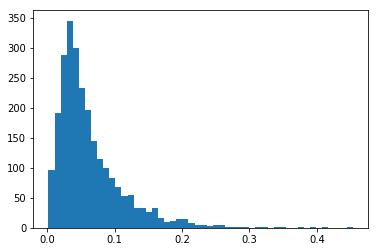

In [164]:
plt.hist(errors_45deg, bins=50)


(array([ 497.,  851.,  859.,  817.,  628.,  510.,  443.,  415.,  359.,
         321.,  282.,  269.,  221.,  228.,  213.,  201.,  163.,  183.,
         161.,  149.,  136.,  120.,  140.,  123.,  112.,  112.,  101.,
         103.,  105.,  103.,   92.,  101.,   82.,   86.,   79.,   84.,
          81.,   72.,   77.,   79.,   58.,   50.,   38.,   26.,   27.,
          17.,   12.,    3.,    6.,    5.]),
 array([ 0.1010559 ,  0.10966251,  0.11826913,  0.12687575,  0.13548236,
         0.14408898,  0.1526956 ,  0.16130221,  0.16990883,  0.17851544,
         0.18712206,  0.19572868,  0.20433529,  0.21294191,  0.22154853,
         0.23015514,  0.23876176,  0.24736837,  0.25597499,  0.26458161,
         0.27318822,  0.28179484,  0.29040145,  0.29900807,  0.30761469,
         0.3162213 ,  0.32482792,  0.33343454,  0.34204115,  0.35064777,
         0.35925438,  0.367861  ,  0.37646762,  0.38507423,  0.39368085,
         0.40228747,  0.41089408,  0.4195007 ,  0.42810731,  0.43671393,
         0.44532

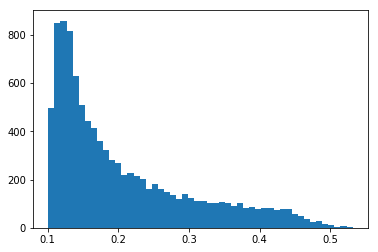

In [135]:
plt.hist(radii_45deg, bins=50)

(array([    3.,     3.,     5.,     9.,    32.,    87.,   316.,  1125.,
          836.,    84.]),
 array([-0.33441682, -0.29204708, -0.24967735, -0.20730761, -0.16493788,
        -0.12256814, -0.08019841, -0.03782867,  0.00454106,  0.0469108 ,
         0.08928053]),
 <a list of 10 Patch objects>)

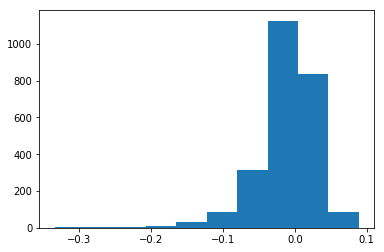

In [165]:
diffs = radii_45deg - errors_45deg
plt.hist(diffs)

(array([   2.,    3.,    2.,    4.,    3.,    5.,    8.,    7.,   10.,
          13.,    8.,    8.,    8.,    6.,   12.,    5.,   12.,    9.,
          10.,   14.,   16.,   25.,   30.,   34.,   35.,   59.,   41.,
          54.,   69.,   69.,   78.,   76.,   90.,  117.,  123.,  122.,
         136.,  107.,  149.,  149.,  118.,  119.,   89.,   88.,   87.,
          78.,   78.,   66.,   31.,   18.]),
 array([-2.93681086, -2.85888887, -2.78096688, -2.70304489, -2.6251229 ,
        -2.54720091, -2.46927893, -2.39135694, -2.31343495, -2.23551296,
        -2.15759097, -2.07966898, -2.00174699, -1.923825  , -1.84590301,
        -1.76798103, -1.69005904, -1.61213705, -1.53421506, -1.45629307,
        -1.37837108, -1.30044909, -1.2225271 , -1.14460511, -1.06668313,
        -0.98876114, -0.91083915, -0.83291716, -0.75499517, -0.67707318,
        -0.59915119, -0.5212292 , -0.44330721, -0.36538523, -0.28746324,
        -0.20954125, -0.13161926, -0.05369727,  0.02422472,  0.10214671,
         0.18006

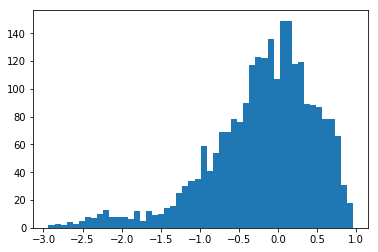

In [168]:
plt.hist(diffs/radii_45deg, bins=50) #,histtype='step',cumulative=True)